# Import all Modules

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

# Check if Cuda is Available

In [ ]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 626.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.3/760.3 kB 5.3 MB/s eta 0:00:0000:0100:01


In [ ]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.4 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


# Setting up the dataset paths

In [ ]:
dataset_path = '/kaggle/input/car-plate-detection' # Path to your dataset

In [ ]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)

    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

# Example usage
print(the_number_in_the_string("file123.txt"))  # Output: 123
print(the_number_in_the_string("no_numbers_here"))  # Output: 0

123
0


# Formatting the XML File and creating DF

In [ ]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob

# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()

    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [ ]:
import os
import shutil
import pandas as pd

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [ ]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/kaggle/input/car-plate-detection/images/Cars1...,305,320,256,267,400,267
315,/kaggle/input/car-plate-detection/images/Cars3...,12,385,98,181,400,300
282,/kaggle/input/car-plate-detection/images/Cars2...,37,319,145,203,350,263
236,/kaggle/input/car-plate-detection/images/Cars2...,223,250,106,119,400,176
112,/kaggle/input/car-plate-detection/images/Cars1...,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/kaggle/input/car-plate-detection/images/Cars1...,286,328,133,159,400,267
255,/kaggle/input/car-plate-detection/images/Cars2...,116,273,156,188,400,267
292,/kaggle/input/car-plate-detection/images/Cars2...,91,137,187,208,400,267
54,/kaggle/input/car-plate-detection/images/Cars5...,148,257,61,118,400,300


In [ ]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)

    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [ ]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [ ]:
os.getcwd()

'/kaggle/working'

![image.png](attachment:00956efa-22a1-49e2-b986-52c97b903c36.png)

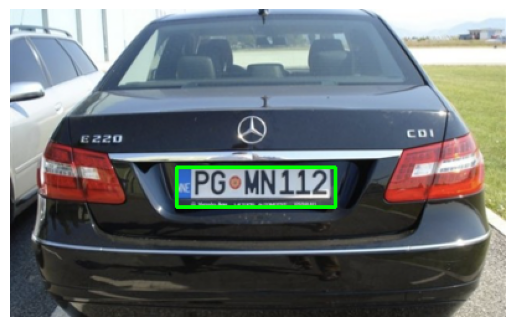

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [ ]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

TRAINING THE MODEL FOR 100 EPOCHS

In [ ]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics YOLOv8.2.20 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 452.53it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 192.95it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 399.51it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 165.30it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.908G      1.738      2.999      1.337         18        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         44         44    0.00334      0.932      0.469      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.849G      1.491      1.543      1.115         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44    0.00453      0.864      0.256      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.858G      1.567      1.419      1.168         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all         44         44      0.786      0.455      0.643      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.872G      1.537      1.312      1.168         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


                   all         44         44      0.648      0.318      0.468      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.872G      1.493      1.284      1.155         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44      0.308      0.152      0.114     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.872G      1.539       1.28      1.216         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]

                   all         44         44      0.455      0.418      0.479       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.866G      1.475      1.212      1.206         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.808      0.764      0.805      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.872G      1.421      1.073      1.153         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]


                   all         44         44      0.864      0.545      0.734      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.866G      1.435      1.051      1.167         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]

                   all         44         44      0.803       0.75      0.802      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.872G      1.421       1.06       1.11         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


                   all         44         44      0.539      0.841      0.689      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.866G      1.406      0.989      1.135         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.917      0.757       0.83      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.872G      1.398     0.9523      1.138         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

                   all         44         44      0.776      0.773      0.783       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.866G       1.41     0.9539      1.123         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         44         44      0.834      0.802      0.858      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.872G       1.33      0.938      1.108         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         44         44      0.942      0.841      0.878      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.864G      1.393     0.9365      1.127         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

                   all         44         44       0.88      0.886      0.875      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.872G      1.272     0.8818      1.069         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         44         44      0.916      0.741      0.859      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.866G      1.254     0.8556      1.099         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]

                   all         44         44      0.746      0.795      0.762      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.872G      1.275     0.8217      1.116         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.99it/s]


                   all         44         44      0.605      0.731      0.724      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.866G      1.285     0.8428        1.1         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         44         44      0.874      0.864       0.86      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.872G      1.277     0.8308      1.106         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         44         44      0.835      0.909      0.912      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.866G       1.25     0.8446      1.064         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]

                   all         44         44      0.802      0.841      0.843      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.872G       1.28     0.8228      1.073         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]

                   all         44         44      0.944      0.769      0.878      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.866G      1.232     0.8008      1.059         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]

                   all         44         44      0.899      0.813      0.864      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.872G      1.147     0.7603      1.038         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         44         44      0.821      0.886      0.886      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.866G      1.158     0.7638      1.034         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.72it/s]

                   all         44         44      0.788      0.841      0.858      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.872G       1.18     0.7689      1.033         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.951      0.881      0.951      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.866G      1.142     0.7261      1.022         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]

                   all         44         44      0.893      0.955       0.94      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.872G      1.123     0.7267      1.009         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


                   all         44         44      0.888      0.898      0.922      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.866G      1.096     0.7086      1.002         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         44         44      0.917      0.841      0.916      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.872G      1.134     0.7363      1.019         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


                   all         44         44      0.943      0.886      0.938      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.866G      1.103     0.7101      1.009         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         44         44       0.88      0.831      0.897      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.872G      1.134     0.6935       1.02         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


                   all         44         44      0.875      0.799      0.887      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.866G      1.126     0.7077      1.021         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]

                   all         44         44       0.95      0.859      0.928      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.872G      1.159     0.7075      1.029         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]


                   all         44         44      0.898      0.841      0.871      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.866G      1.086     0.6733     0.9929         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]


                   all         44         44      0.927       0.75      0.884      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.872G      1.087     0.6653      1.003         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


                   all         44         44      0.828      0.864      0.883      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.866G      1.069     0.6798       1.03         21        320: 100%|██████████| 22/22 [00:02<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         44         44      0.883      0.864      0.874      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.872G      1.061     0.6516     0.9921         25        320: 100%|██████████| 22/22 [00:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


                   all         44         44      0.917      0.886      0.884      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.864G      1.025     0.6449      0.979         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


                   all         44         44      0.889      0.908      0.914      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.872G      1.032     0.6382     0.9795         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


                   all         44         44       0.88      0.864      0.917      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.864G      1.064     0.6321     0.9927         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

                   all         44         44      0.926      0.858      0.914      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.872G      1.018     0.6275     0.9855         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.23it/s]


                   all         44         44      0.899      0.886      0.909       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.866G      1.012     0.6373      0.992         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         44         44      0.903      0.886      0.916      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.872G      1.037     0.6488      1.001         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


                   all         44         44      0.865      0.909      0.925      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.866G      1.041     0.6428      1.008         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]

                   all         44         44      0.887      0.894      0.918      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.872G      0.985     0.6042     0.9729         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44      0.904      0.855      0.922      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.866G       1.04     0.6077     0.9804         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         44         44      0.921      0.886      0.907      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.872G       1.02     0.5902     0.9904         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


                   all         44         44      0.948      0.834      0.905      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.864G      0.984     0.6111     0.9802         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         44         44      0.884      0.932       0.93      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.872G       0.99     0.5874     0.9691         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         44         44      0.862      0.909      0.938       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.866G     0.9634     0.5901     0.9599         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         44         44      0.895      0.886      0.912      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.872G      1.019     0.6198      0.959         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


                   all         44         44      0.849      0.932      0.935      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.866G      0.958     0.5805     0.9687         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]

                   all         44         44      0.902       0.84      0.899      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.872G     0.9381     0.5715     0.9527         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]

                   all         44         44      0.881      0.839      0.911       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.866G     0.9109     0.5745     0.9393         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


                   all         44         44      0.898      0.799      0.891      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.872G     0.9129     0.5475     0.9449         11        320: 100%|██████████| 22/22 [00:01<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.63it/s]

                   all         44         44       0.88      0.773      0.875      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.866G      0.947     0.5711     0.9422         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         44         44      0.899      0.811      0.865      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.872G     0.8996     0.5522     0.9566         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]


                   all         44         44      0.854      0.864      0.893      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.866G     0.9241       0.56     0.9488         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]

                   all         44         44      0.919      0.773      0.894       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.872G     0.9213     0.5585     0.9745         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         44         44      0.952      0.795      0.889      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.866G      0.904     0.5568     0.9205         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


                   all         44         44      0.907      0.841      0.905      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.872G     0.8701      0.537     0.9409         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         44         44      0.898      0.841      0.916      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.866G     0.8913     0.5345     0.9399         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


                   all         44         44      0.898      0.798       0.92      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.872G     0.8903     0.5345     0.9546         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         44         44      0.948      0.795      0.911      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.866G     0.8846     0.5252     0.9343         24        320: 100%|██████████| 22/22 [00:01<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44      0.942      0.795      0.908      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.872G     0.8449     0.5265     0.9228         24        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


                   all         44         44      0.922       0.81      0.899      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.866G     0.9062     0.5264     0.9505         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]

                   all         44         44      0.927      0.818      0.892      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.872G     0.8601     0.5127     0.9254         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         44         44      0.911      0.864      0.932      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.866G     0.9072     0.5299     0.9474         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         44         44      0.912      0.818       0.92      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.872G     0.8466     0.5163     0.9344         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


                   all         44         44      0.925      0.864      0.915      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.866G     0.8511     0.5018     0.9377         24        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]

                   all         44         44      0.931      0.841      0.911      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      0.87G     0.8376     0.5056      0.928         10        320: 100%|██████████| 22/22 [00:01<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]

                   all         44         44      0.964      0.818      0.915      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.866G     0.8178     0.4969     0.9241         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44      0.863      0.864      0.893      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.872G     0.8267     0.4929     0.9231         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.75it/s]

                   all         44         44      0.843      0.864      0.894      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.866G     0.7835     0.4905     0.9056         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

                   all         44         44      0.907      0.773      0.873      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.872G     0.8195     0.5119     0.9177         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

                   all         44         44      0.832      0.902      0.912        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.866G     0.8187     0.4918     0.9268         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         44         44      0.831      0.909      0.904       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.872G     0.8129     0.5061     0.9045         16        320: 100%|██████████| 22/22 [00:02<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


                   all         44         44      0.912      0.795      0.886       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.866G     0.8528     0.4958     0.9363         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


                   all         44         44      0.847      0.882       0.89       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.872G     0.8588     0.5127     0.9297         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]

                   all         44         44      0.881      0.841      0.882      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.866G     0.7719     0.4731     0.9123         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]

                   all         44         44       0.87      0.841      0.906      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.872G     0.7517     0.4526     0.9111         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]

                   all         44         44      0.864      0.863      0.908      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.866G       0.79     0.4595     0.9181         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         44         44      0.921      0.792      0.905      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.872G     0.7789     0.4634     0.9172         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]

                   all         44         44      0.881      0.864      0.911      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.866G     0.7878     0.4696     0.9189         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         44         44      0.942      0.818      0.903      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.872G     0.7711     0.4576     0.9227         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


                   all         44         44      0.885      0.886      0.924      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.866G     0.8096     0.4769     0.9307         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

                   all         44         44      0.868      0.886       0.92      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.872G     0.7595     0.4722     0.8981         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]

                   all         44         44      0.883      0.886       0.92      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.866G     0.7744     0.4634     0.9255         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

                   all         44         44       0.88      0.886      0.919      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.872G     0.7365      0.449     0.9156         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]


                   all         44         44      0.858      0.841      0.894      0.514
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.864G     0.9851      0.535      1.017          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]

                   all         44         44       0.85      0.904        0.9      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      0.87G      1.019     0.5256     0.9992          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         44         44      0.863      0.886      0.897      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.864G     0.9682      0.526     0.9988          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all         44         44      0.847      0.878      0.896      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      0.87G     0.9592     0.4964     0.9879          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]

                   all         44         44      0.847       0.88      0.893      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.864G     0.9413     0.4835     0.9744          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44       0.84      0.864      0.895      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      0.87G     0.9362     0.4928     0.9857          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

                   all         44         44      0.843      0.864      0.895      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.864G     0.9538       0.49     0.9935          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         44         44      0.832      0.886      0.902      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      0.87G     0.9355     0.4874     0.9675          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         44         44      0.834      0.909      0.903      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.864G     0.9132     0.4738     0.9741          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]

                   all         44         44      0.842      0.909      0.901      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      0.87G     0.9031     0.4867     0.9742          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]

                   all         44         44       0.86      0.909      0.901       0.51



100 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.20 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


                   all         44         44      0.863      0.862      0.907      0.539
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▄▁▅▆▇▇▅▆▇██▇▇▇▇▇███▇▇▇▇▇▇▇█▇▇▇▇▇▇██▇▇▇▇
metrics/mAP50-95(B),▁▄▂▅▅▆▆▄▆▇▇▇▆▆▇▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇▇▇▇██
metrics/precision(B),▁▇▄▇█▇█▅▇██▇▇█▇▇█▇█▇▇▇▇██████▇▇▇▇▇▇▇▇▇▇▇
metrics/recall(B),█▂▁▃▆▆▅▅▇▆▇█▇▇▇█▇█▇█▇▇▆▆▇▆▆▆▆▇█▇▇▇▇▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▆▆▆▅▅▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▃▂▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b06441b9d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

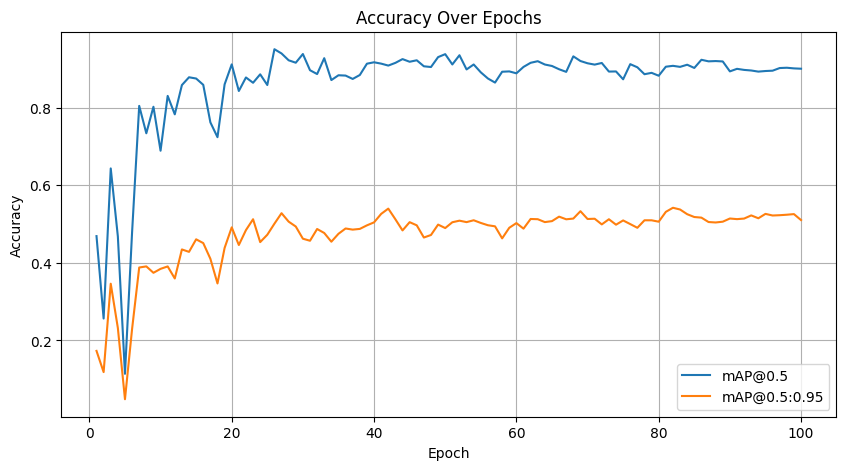

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 58.5ms
Speed: 0.9ms preprocess, 58.5ms inference, 15.5ms postprocess per image at shape (1, 3, 160, 320)


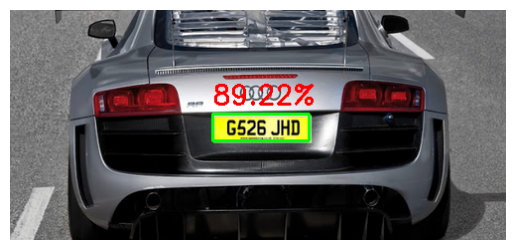

In [ ]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 1 license_plate, 46.4ms
Speed: 0.8ms preprocess, 46.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


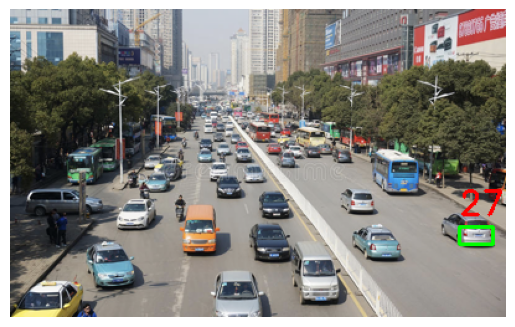

In [ ]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 42.2ms
Speed: 0.8ms preprocess, 42.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)


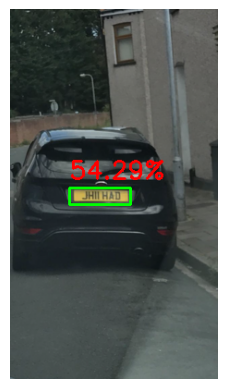

In [ ]:
predict_and_plot(test.iloc[2].img_path)

# Implementing Text Extraction

In [ ]:
!pip3 install pytesseract

In [ ]:
import pytesseract
from pytesseract import Output

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 42.6ms
Speed: 1.1ms preprocess, 42.6ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 320)
Detected text: G526 JHD



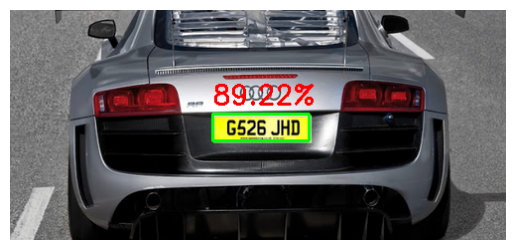

In [ ]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 1 license_plate, 34.6ms
Speed: 0.9ms preprocess, 34.6ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)
Detected text: =



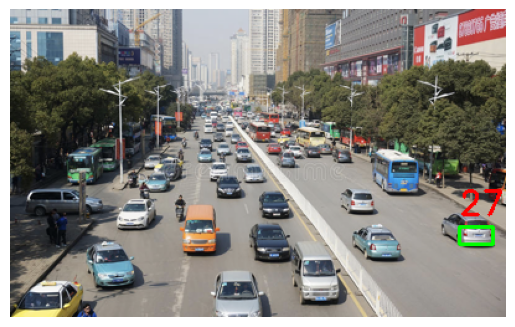

In [ ]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 34.1ms
Speed: 0.9ms preprocess, 34.1ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)
Detected text: [ JHTHAD |



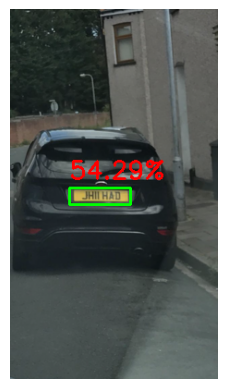

In [ ]:
predict_and_plot(test.iloc[2].img_path)